# Final Project Sketch :(


In [1]:
import pandas as pd
import numpy as np
import os
from math import sin, cos, sqrt, atan2, radians, log
import time
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import TimeSeriesSplit
import holidays

%matplotlib inline

pd.set_option('display.max_columns', 500)
#os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="E:/GitHub/NYU-Taxi-project/My First Project-b3735f3b3a9d.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="D:/Projects/NYC-Taxi-FHV-Project/My First Project-b3735f3b3a9d.json"
from google.cloud import bigquery
client = bigquery.Client()

import urllib        #for url stuff
import re            #for processing regular expressions
# import scipy         #for other dependancies
from sklearn.cluster import KMeans # for doing K-means clustering
#from haversine import haversine # for calculating haversine distance
import seaborn as sns #for making plots
import os  # for os commands
from scipy.misc import imread, imresize, imsave  # for plots 
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
import io
import base64
output_notebook()
# plotly.offline.init_notebook_mode() # run at the start of every ipython notebook
# import plotly.plotly as py
# import plotly.graph_objs as go
# import plotly
# plotly.tools.set_credentials_file(username='zxf71699', api_key='BkltlyEFcOkOAgCSdkjt')


Loading BokehJS ...

## Query Data from BigQuery

In [2]:
start = time.time()
query = (
"""
SELECT travel_time, date_of_year, month_of_year, day_of_year, pickup_hour,
    dropoff_datetime,pickup_datetime,
    pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,
    temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
FROM
(
      SELECT *,ROW_NUMBER() OVER(partition by date_of_year, pickup_hour) as row_number
      FROM
      (
            SELECT pickup_datetime, dropoff_datetime, pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude,
            EXTRACT (HOUR FROM pickup_datetime) as pickup_hour,
            EXTRACT (DAY FROM pickup_datetime) as day_of_year,
            EXTRACT (MONTH FROM pickup_datetime) as month_of_year,
            EXTRACT (DATE FROM pickup_datetime) as date_of_year,
            TIMESTAMP_DIFF(TIMESTAMP(dropoff_datetime), TIMESTAMP(pickup_datetime), SECOND) as travel_time,
            passenger_count
            FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
            WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL and
                dropoff_longitude IS NOT NULL and dropoff_latitude IS NOT NULL
      ) x
) x
JOIN
(
 select cast(mo as int64) as month,cast(da as int64) as day,temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
 from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
) y on x.month_of_year = y.month and x.day_of_year = y.day
where x.row_number <= 200
"""
)
data=pd.io.gbq.read_gbq(query,dialect='standard')
end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

Time taken by above cell is 5.650006767114004.


### Create new features

In [3]:
# create weekday
data["weekday"] = data['pickup_datetime'].dt.dayofweek

# create travel time
data['travel_time'] = round(data['travel_time'], 2)

# create holiday
us_holidays = holidays.UnitedStates()
data['holiday'] = data['date_of_year'].apply(lambda x: 1 if x in us_holidays else 0)

# distiance_in_km
R = 6373.0

dlon = np.radians(data['dropoff_longitude']) - np.radians(data['pickup_longitude'])
dlat = np.radians(data['dropoff_latitude']) - np.radians(data['pickup_latitude'])

a = np.sin(dlat / 2)**2 + np.cos(data['pickup_latitude']) * np.cos(data['dropoff_latitude']) * np.sin(dlon / 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

data['distance_in_km'] = round(R*c,3)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


## Optimize the memory usage

In [4]:
# Create a function to be calculating memory usage
def get_usage(obj):
    if isinstance(obj, pd.DataFrame):
        usage = obj.memory_usage(deep=True).sum()
    else:
        usage = obj.memory_usage(deep=True)
    return "{:03.2f} MB".format(usage / (1024**2))

# Convert object to int
obj = data.select_dtypes(include = 'object')
obj_f32 = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert int64 to int8
obj = data.select_dtypes(include = 'int64')
obj_int = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert float64 to float32
obj = data.select_dtypes(include = 'float64')
obj_f = obj.apply(pd.to_numeric, downcast='float')

# Calculated the memory we reduced by down grade int and float
print("Original memory usage: ", get_usage(data))
data[obj_f32.columns] = obj_f32
data[obj_int.columns] = obj_int
data[obj_f.columns] = obj_f
print("After converting int and float memory usage: ", get_usage(data))

Original memory usage:  510.47 MB
After converting int and float memory usage:  95.53 MB


## Process Missing Data & Outlier

### Weather Data Cleaning

In [5]:
# refill visib using forward or backward
data['visib'] = data['visib'].replace(999.9, np.nan).fillna(method='ffill')

# for i in data.loc[(data['visib']== 999.9), 'date_of_year'].unique():
#     data.loc[data['date_of_year'] == i,'visib'] =  data.loc[data['date_of_year'] == pd.to_datetime(i) - datetime.timedelta(1),'visib'].unique()

# refill mxpsd using forward or backward
data['mxpsd'] = data['mxpsd'].replace(999.9, np.nan).fillna(method='ffill')              

# for i in data.loc[(data['mxpsd']== 999.9), 'date_of_year'].unique():
#     data.loc[data['date_of_year'] == i,'mxpsd'] =  data.loc[data['date_of_year'] == pd.to_datetime(i) - datetime.timedelta(1),'mxpsd'].unique()

# refill wdsp using forward or backward
data['wdsp'] = data['wdsp'].replace(999.9, np.nan).fillna(method='ffill')              

# for i in data.loc[(data['mxpsd']== 999.9), 'date_of_year'].unique():
#     data.loc[data['date_of_year'] == i,'mxpsd'] =  data.loc[data['date_of_year'] == pd.to_datetime(i) - datetime.timedelta(1),'mxpsd'].unique()

# refill gust as 0
data.loc[(data['gust'] == 999.9), 'gust'] = 0

# refit sndp as 0
data.loc[data['sndp'] == 999.9, 'sndp'] = 0

### Taxi Data cleaning

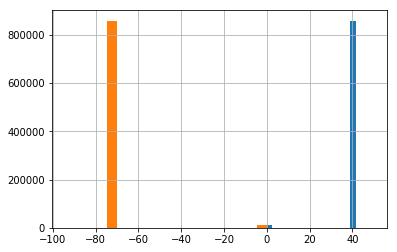

In [6]:
data['pickup_latitude'].hist(bins=20)
data['pickup_longitude'].hist(bins=20)

# remove any pickup not in the manha
data = data[(data['pickup_longitude'] >= -79.7624) & (data['pickup_longitude'] <= -71.7517) &
                    (data['pickup_latitude'] >= 40.4772) & (data['pickup_latitude'] <= 45.0153)]

data = data[(data['dropoff_longitude'] >= -79.7624) & (data['dropoff_longitude'] <= -71.7517) &
                    (data['dropoff_latitude'] >= 40.4772) & (data['dropoff_latitude'] <= 45.0153)]

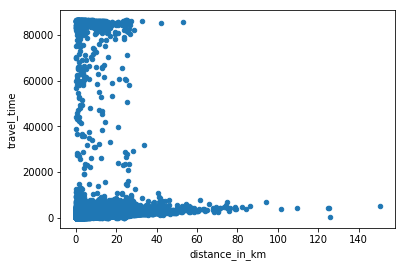

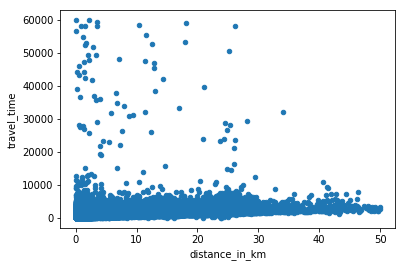

In [7]:
# remove duration is over 1000 mins, and distance is far away 50 km
data.plot(x='distance_in_km',y='travel_time',kind='scatter')

data = data[(data['travel_time']>0) & (data['distance_in_km']<50)  & (data['travel_time']<60000)]

data.plot(x='distance_in_km',y='travel_time',kind='scatter')

## Feature Engineer

### Create Dummy

In [ ]:
data_month = pd.get_dummies(data['month_of_year'])
data_month.columns = ['month_' + str(col) for col in data_month.columns]

data_hour = pd.get_dummies(data['pickup_hour'])
data_hour.columns = ['hour_' + str(col) for col in data_hour.columns]

data_day = pd.get_dummies(data['day_of_year'])
data_day.columns = ['day_' + str(col) for col in data_day.columns]

# 0 for Monday
data_week = pd.get_dummies(data['weekday'])
data_week.columns = ['week_' + str(col) for col in data_week.columns]

data = pd.concat([data, data_month, data_week, data_day, data_hour], axis=1)

### Bearing

In [8]:
def bearing_array(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

data['bearing'] = bearing_array(data['pickup_latitude'],data['pickup_longitude'],data['dropoff_latitude'],data['dropoff_longitude'])

#### K-Means Cluster

In [10]:
start = time.time()

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

location = data.loc[:, ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]

kmeans = KMeans(n_clusters=50, random_state=123, n_init = 10).fit(location)
location['label'] = kmeans.labels_

data['locationID'] = location['label']

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

Time taken by above cell is 11.300488392512003.


In [13]:
data.shape

(855855, 31)

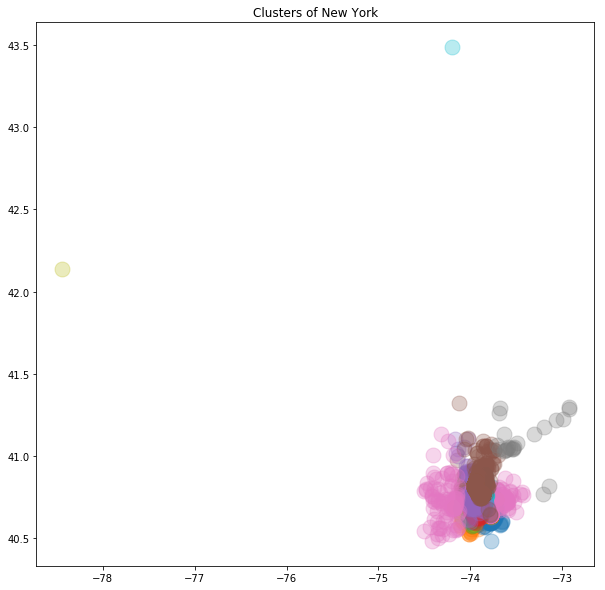

In [14]:
plt.figure(figsize = (10,10))
for label in location.label.unique():
    plt.plot(location.pickup_longitude[location.label == label],location.pickup_latitude[location.label == label],'.', alpha = 0.3, markersize = 30)

plt.title('Clusters of New York')
plt.show()

### Geohash

In [15]:
from __future__ import print_function, division
import geopandas as gpd
import shapely
import pysal as ps
from fiona.crs import from_epsg
from shapely.geometry import Polygon
import geopandas as gpd
import geohash_hilbert as ghh
import choroplethNYC as cp
#!pip install geohash_hilbert 
#!pip install geopandas 
#!pip install pysal
#!pip install shapely

D:\ProgramData\Anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [16]:
geo = []
for i in range(len(data)):
    value = ghh.encode(data.pickup_longitude.iloc[i], data.pickup_latitude.iloc[i], precision=5)
    geo.append(value)
data['geohash'] = geo
# data['pickups'] = np.ones(df1.shape[0])

data["geohash"] = data["geohash"].astype('category')
data.dtypes
data["geohash"] = data["geohash"].cat.codes

## Modeling

### Split Training and Test

In [17]:
from sklearn.model_selection import train_test_split
selected_features = ['month_of_year', 'day_of_year', 'pickup_hour', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'geohash', 'bearing',  'prcp', 'sndp', 'fog', 'weekday', 'holiday', 'distance_in_km']

x = data[selected_features]
y = np.log(data['travel_time'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [18]:
def train_test_model_performance(clf, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):
    
    # Fit a model by providing X and y from training set
    clf.fit(x_train, y_train)
    print(clf)
    # Make prediction on the training data
    y_train_pred = clf.predict(x_train)

    # Make predictions on test data
    y_test_pred = clf.predict(x_test)
    
    # Evaluate
    R2_Train = clf.score(x_train,y_train)
    R2_Test = clf.score(x_test,y_test)
    RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
    RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))
    RMSLE_Train = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
    RMSLE_Test = np.sqrt(mean_squared_log_error(y_test, y_test_pred))
    
    metric_names = ['R2','RMSE','RMSLE']
    metric_values_train = [R2_Train, RMSE_Train, RMSLE_Train]
    metric_values_test = [R2_Test, RMSE_Test, RMSLE_Test]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

### Random Forest

In [29]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

start = time.time()

parameters = {'n_estimators': 400,
             'max_features': 'auto',
             #'criterion': 'gini',
              'max_depth': 40,
              'min_samples_split': 30,
              'random_state': 123,
              'n_jobs': -1
              }

rf = RandomForestRegressor(**parameters)
train_test_model_performance(rf)

# print("R2:", round(rf.score(x_test,y_test),3))
# print("MSE:", round(mean_squared_error(y_test, rf.predict(x_test)),3))
end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=30,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
           oob_score=False, random_state=123, verbose=0, warm_start=False)
            train      test
metrics                    
R2       0.880470  0.793229
RMSE     0.276658  0.364028
RMSLE    0.046010  0.059588
Time taken by above cell is 7.5991774837176.


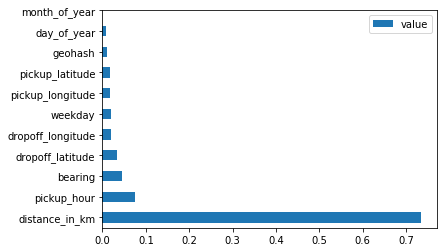

In [31]:
features = pd.DataFrame(list(zip(selected_features, rf.feature_importances_))).sort_values(by=[1], ascending=False)
features.columns = ['feature', 'value']
features.head(10)

ax = features.iloc[0:10].plot.barh()
t = np.arange(11)
ax.set_yticks(t)
ax.set_yticklabels(features['feature'])
plt.show()

### Gradient Boosting Trees

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

start = time.time()

x_train_small = x_train[features.iloc[0:10]['feature'].values]
x_test_small = x_test[features.iloc[0:10]['feature'].values]

# Choose some parameter combinations to try
parameters = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.2,
    'subsample': 0.7,
    'max_features':0.7,
    'random_state': 2
}

GBDT = GradientBoostingRegressor(**parameters)
train_test_model_performance(GBDT, x_train = x_train_small, x_test = x_test_small)

# GBDT.fit(x_train, y_train)
# print("R2: ", round(GBDT.score(x_test, y_test),3))
# print("MSE: ", round(mean_squared_error(y_test, GBDT.predict(x_test)),3))

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

### HyperParameter Tuning: Grid Search

### RF

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

start = time.time()

# Choose the type of classifier. 
rf = RandomForestRegressor()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [400, 500, 600], 
              'max_features': ['auto'], 
              'max_depth': [25,30,35], 
#               'min_samples_split': [2],
               'min_samples_leaf': [2,5,7,10],
              'n_jobs':[-1]
             }

# read theory
grid_obj = GridSearchCV(rf, param_grid, cv=3)
grid_obj = grid_obj.fit(x_train, y_train)

rf_cv = grid_obj.best_estimator_
train_test_model_performance(rf_cv)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [400, 500, 600], 'max_features': ['auto'], 'max_depth': [25, 30, 35], 'min_samples_leaf': [2, 5, 7, 10], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
            train      test
metrics                    
R2       0.937195  0.678010
RMSE     0.160038  0.363526
RMSLE    0.030191  0.063487
Time taken by above cell is 79.01845415830613.


### GBDT

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

start = time.time()
GBDT = GradientBoostingRegressor()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [100,125,150], 
              'max_features': [0.8], 
              'max_depth': [7,9,11], 
                'learning_rate': [0.1],
                'subsample': [0.7]
             }

# read theory
grid_obj = GridSearchCV(GBDT, param_grid, cv=3)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
GBDT_cv = grid_obj.best_estimator_
train_test_model_performance(GBDT_cv)


# print("R2: ", round(GBDT_cv.score(x_test,y_test),4))
# print("MSE:", round(mean_squared_error(y_test, GBDT_cv.predict(x_test)),4))

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=0.8,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=0.7, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
            train      test
metrics                    
R2       0.770527  0.686395
RMSE     0.305909  0.358761
RMSLE    0.050081  0.062707
Time taken by above cell is 25.093386987845104.


### Linear model

In [ ]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha = 0.1)

train_test_model_performance(reg)

In [115]:
start = time.time()
reg = Lasso()

# Choose some parameter combinations to try
param_grid = {'alpha' = [0.1,0.3,0.5,0.7]}

# read theory
grid_obj = GridSearchCV(reg, param_grid, cv=3)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
reg.cv = grid_obj.best_estimator_
train_test_model_performance(cv)


# print("R2: ", round(GBDT_cv.score(x_test,y_test),4))
# print("MSE:", round(mean_squared_error(y_test, GBDT_cv.predict(x_test)),4))

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

0.4722181132639865